# Heart Disease Detection via Multi-View MIL: SAMIL Reproduction

Huang, Z., Wessler, B. S., & Hughes, M. C. (2023). Detecting Heart Disease from Multi-View Ultrasound Images via Supervised Attention Multiple Instance Learning. Proceedings of the 8th Machine Learning for Healthcare Conference, PMLR 219:285–307.

In [17]:
!pip install pytorch-metric-learning

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# === Standard Libraries ===
import os
import sys
import random
import logging
from collections import defaultdict

# === Data Handling ===
import pandas as pd
from PIL import Image

# === PyTorch and TorchVision ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

# === Metric Learning ===
from pytorch_metric_learning import losses

# === Sklearn Utilities ===
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score

# === Progress Display ===
from tqdm import tqdm

# === Local Project Code ===
sys.path.append('/content/gdrive/MyDrive/dlh project/SAMIL/src/SAMIL/')
from libml.models.view_classifier import build_wideresnet

## Data Loading and Preprocessing

In [4]:
# Define paths
data_dir = '/content/gdrive/MyDrive/dlh project/view_and_diagnosis_labeled_set'
labeled_dir = os.path.join(data_dir, 'labeled')
unlabeled_dir = os.path.join(data_dir, 'unlabeled')
labels_csv = os.path.join(data_dir, 'labels_per_image.csv')

# Load CSV with labels
labels_df = pd.read_csv(labels_csv)

# Filter labels_df to include only existing files in the labeled directory
labels_df = labels_df[labels_df['query_key'].apply(lambda x: os.path.isfile(os.path.join(labeled_dir, x)))].reset_index(drop=True)

# Function to extract study_id from filename
def extract_study_id(query_key):
    return query_key.split('_')[0]  # e.g., '3407s1' from '3407s1_0.png'

# Apply function to dataframe
labels_df['study_id'] = labels_df['query_key'].apply(extract_study_id)

# Clean labels
labels_df['view_label'] = labels_df['view_label'].str.strip()
labels_df['diagnosis_label'] = labels_df['diagnosis_label'].str.strip()

# Create mapping: image path -> labels (for supervised learning)
image_to_labels = {}
for _, row in labels_df.iterrows():
    img_filename = row['query_key']
    img_path = os.path.join(labeled_dir, img_filename)
    image_to_labels[img_path] = {
        "view_label": row['view_label'],
        "diagnosis_label": row['diagnosis_label']
    }

# Get all image filenames in the unlabeled directory
unlabeled_image_paths = [os.path.join(unlabeled_dir, filename) for filename in os.listdir(unlabeled_dir) if os.path.isfile(os.path.join(unlabeled_dir, filename))]

# Create mapping: study_id -> list of image paths (for contrastive learning)
study_to_images = defaultdict(list)
for img_path in unlabeled_image_paths:
    study_id = extract_study_id(os.path.basename(img_path))
    study_to_images[study_id].append(img_path)

In [5]:
class EchoDataset(Dataset):
    def __init__(self, image_paths, image_to_labels=None, transform=None, augment_transform=None, all_view_labels=None):
        """
        Args:
            image_paths (list): List of image file paths.
            image_to_labels (dict, optional): Mapping from image path to labels.
            transform (callable, optional): Optional transform to be applied on an image (e.g., resize and to tensor).
            augment_transform (callable, optional): Optional transform for augmenting images (e.g., random crop, flip).
            all_view_labels (list, optional): List of all possible view labels for label encoding.
        """
        self.image_paths = image_paths
        self.image_to_labels = image_to_labels
        self.transform = transform
        self.augment_transform = augment_transform

        # Initialize LabelEncoder
        self.view_label_encoder = LabelEncoder()
        self.diagnosis_label_encoder = LabelEncoder()

        # Fit the LabelEncoder with all unique view labels from your dataset if image_to_labels is provided
        if image_to_labels is not None:  # Check if image_to_labels is provided
            all_view_labels = list(set(v['view_label'] for v in image_to_labels.values()))
            self.view_label_encoder.fit(all_view_labels)  # Fit the encoder
            all_diagnosis_labels = list(set(v['diagnosis_label'] for v in image_to_labels.values()))
            self.diagnosis_label_encoder.fit(all_diagnosis_labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Apply augmentations first
        view1 = self.augment_transform(image) if self.augment_transform else image
        view2 = self.augment_transform(image) if self.augment_transform else image

        # Now apply the usual transforms (like resizing and converting to tensor)
        if self.transform:
            view1 = self.transform(view1)
            view2 = self.transform(view2)

        if self.image_to_labels:
            labels = self.image_to_labels.get(img_path, {})
            view_label = labels.get('view_label')
            diagnosis_label = labels.get('diagnosis_label')

            # Encode the labels
            view_label = self.view_label_encoder.transform([view_label])[0]
            diagnosis_label = self.diagnosis_label_encoder.transform([diagnosis_label])[0]

            return view1, view2, view_label, diagnosis_label
        else:
            return view1, view2

In [6]:
# List of image paths with labels
labeled_image_paths = list(image_to_labels.keys())

# Flatten the list of image paths from all studies
unlabeled_image_paths = [img_path for images in study_to_images.values() for img_path in images]

# Define base transformations (resize and to tensor)
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Define augmentation transformations (e.g., random horizontal flip, rotation, etc.)
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    #transforms.ToTensor(),
])

# Create the supervised dataset with augmentations
supervised_dataset = EchoDataset(
    image_paths=labeled_image_paths,
    image_to_labels=image_to_labels,
    transform=base_transform,
    augment_transform=augment_transform
)

# Create the self-supervised dataset with augmentations
self_supervised_dataset = EchoDataset(
    image_paths=unlabeled_image_paths,
    transform=base_transform,  # Base transform for resizing and tensor conversion
    augment_transform=augment_transform  # Augmentation for self-supervised learning
)


In [7]:
# Define the sizes for training, validation, and test sets
total_size = len(supervised_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Ensures all data is used

# Set a random seed for reproducibility
torch.manual_seed(42)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    supervised_dataset, [train_size, val_size, test_size]
)

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Define the sizes for training, validation, and test sets
unlabeled_total_size = len(self_supervised_dataset)
unlabeled_train_size = int(0.8 * unlabeled_total_size)
unlabeled_val_size = int(0.1 * unlabeled_total_size)
unlabeled_test_size = unlabeled_total_size - unlabeled_train_size - unlabeled_val_size

# Split the dataset
unlabeled_train_dataset, unlabeled_val_dataset, unlabeled_test_dataset = random_split(
    self_supervised_dataset, [unlabeled_train_size, unlabeled_val_size, unlabeled_test_size]
)

# Create DataLoaders for each set
unlabeled_train_loader = DataLoader(unlabeled_train_dataset, batch_size=8, shuffle=True, num_workers=4)
unlabeled_val_loader = DataLoader(unlabeled_val_dataset, batch_size=8, shuffle=False, num_workers=4)
unlabeled_test_loader = DataLoader(unlabeled_test_dataset, batch_size=8, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Model Training

In [8]:
def pretrain(model, pretrain_loader, contrastive_loss_fn, optimizer, device, num_epochs=100):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in pretrain_loader:
            study_view1, study_view2 = batch

            study_view1 = study_view1.to(device)
            study_view2 = study_view2.to(device)

            optimizer.zero_grad()

            z1, _ = model(study_view1)
            z2, _ = model(study_view2)

            # Concatenate embeddings and create labels
            embeddings = torch.cat([z1, z2], dim=0)
            labels = torch.arange(z1.size(0)).to(device)
            labels = torch.cat([labels, labels], dim=0)

            # Compute loss
            loss = contrastive_loss_fn(embeddings, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Pretraining Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(pretrain_loader):.4f}')


In [9]:
logger = logging.getLogger(__name__)

def create_view_relevance_classifier():
    base_model = build_wideresnet(depth=28, widen_factor=2, dropout=0.0, num_classes=3) # Original view model

    logger.info("Total params for View Model: {:.2f}M".format(
        sum(p.numel() for p in base_model.parameters()) / 1e6))

    checkpoint_path = '/content/gdrive/MyDrive/dlh project/seed0_model_best.pth.tar'

    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    base_model.load_state_dict(checkpoint['ema_state_dict'])
    base_model.eval()

    # Modify the final layer to output a single probability score
    base_model.fc = nn.Sequential(
        nn.Linear(base_model.fc.in_features, 1),  # Output a single probability
        nn.Sigmoid()  # Apply sigmoid to get probability between 0 and 1
    )

    return base_model  # Return the modified view model as the relevance classifier

def supervised_attention_loss(attention_weights, relevance_scores, tau_v=1.0):
    """
    Calculates the supervised attention loss (LSA) as described in Equation (4).

    Args:
        attention_weights (torch.Tensor): Attention weights (A) produced by the model.
        relevance_scores (torch.Tensor): Relevance scores (R) from the view relevance classifier.
        tau_v (float): Temperature scaling parameter for the softmax transform.

    Returns:
        torch.Tensor: The supervised attention loss.
    """
    # Calculate R (relevance probabilities) using softmax with temperature scaling
    relevance_probabilities = torch.softmax(relevance_scores / tau_v, dim=0)

    # Calculate KL divergence between R and A
    loss = torch.nn.functional.kl_div(
        torch.log(attention_weights),
        relevance_probabilities,
        reduction='batchmean'  # You can change the reduction method if needed
    )

    return loss

class LMFLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(LMFLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

def train_model_with_attention(model, train_loader, val_loader, criterion, attention_loss_fn, optimizer, num_epochs=25, device='cuda', lambda_attention=1.0):
    model.to(device)
    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        for inputs1, inputs2, view_label, diagnosis_label in tqdm(train_loader): # Unpack all 4 values
            inputs = torch.cat([inputs1, inputs2], dim=0) # Concatenate view1 and view2 along dimension 0 to create inputs
            inputs = inputs.to(device)

            # Repeat labels to match the concatenated input size
            labels = torch.tensor(diagnosis_label, device=device).repeat(2)

            optimizer.zero_grad()

            outputs, attention_weights = model(inputs)
            classification_loss = criterion(outputs, labels)

            # Calculate supervised attention loss
            view_relevance_classifier = create_view_relevance_classifier().to(device) # Initialize the view relevance classifier
            relevance_scores = view_relevance_classifier(inputs) # Get relevance scores from the classifier
            attention_loss = supervised_attention_loss(attention_weights, relevance_scores) # Calculate supervised attention loss

            # Calculate total loss
            loss = classification_loss + lambda_attention * attention_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Training Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs1, inputs2, view_label, diagnosis_label in tqdm(val_loader):
                inputs = torch.cat([inputs1, inputs2], dim=0)
                inputs = inputs.to(device)

                # Repeat labels to match the concatenated input size
                labels = torch.tensor(diagnosis_label, device=device).repeat(2)

                outputs, attention_weights = model(inputs)
                classification_loss = criterion(outputs, labels)

                # Assuming you have a way to get view_relevance_scores for validation data
                # Replace this with your actual logic to get relevance scores
                view_relevance_classifier = create_view_relevance_classifier().to(device)
                relevance_scores = view_relevance_classifier(inputs)

                attention_loss = attention_loss_fn(attention_weights, relevance_scores)
                loss = classification_loss + lambda_attention * attention_loss
                val_running_loss += loss.item() * inputs.size(0)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        print(f'Validation Loss: {val_epoch_loss:.4f}')

        # Early stopping
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            trigger_times = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model


In [10]:
# Custom model integrating ResNet and attention mechanism
class ResNetWithAttention(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetWithAttention, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

        # Attention mechanism (could be a simple attention layer)
        self.attention = nn.Sequential(
            nn.Linear(num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        features = self.resnet(x)
        attention_weights = torch.sigmoid(self.attention(features))  # Apply attention (between 0 and 1)
        return features, attention_weights

In [19]:
# Model initialization
model = ResNetWithAttention(num_classes=5)

# Loss functions and optimizer
criterion = LMFLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, weight_decay=0.0001)
contrastive_loss_fn = losses.ContrastiveLoss()
attention_loss_fn = nn.MSELoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Full Training Process:
def train_with_both_labeled_and_unlabeled(model, labeled_train_loader, labeled_val_loader, unlabeled_loader, criterion, attention_loss_fn, contrastive_loss_fn, optimizer, num_epochs=100, device='cuda', lambda_attention=1.0):
    # Step 1: Pretrain on Unlabeled Data
    print("Starting pretraining on unlabeled data...")
    pretrain(model, unlabeled_loader, contrastive_loss_fn, optimizer, device, num_epochs=num_epochs)

    # Step 2: Fine-tune on Labeled Data
    print("Starting fine-tuning on labeled data...")
    model = train_model_with_attention(model, labeled_train_loader, labeled_val_loader, criterion, attention_loss_fn, optimizer, num_epochs=num_epochs, device=device, lambda_attention=lambda_attention)

    return model

In [21]:
# Train the model using both labeled and unlabeled data
trained_model = train_with_both_labeled_and_unlabeled(model, train_loader, val_loader, unlabeled_train_loader, criterion, attention_loss_fn, contrastive_loss_fn, optimizer, num_epochs=20, device='cuda', lambda_attention=1.0)

Starting pretraining on unlabeled data...
Pretraining Epoch [1/20], Loss: 0.9592
Pretraining Epoch [2/20], Loss: 0.8084
Pretraining Epoch [3/20], Loss: 0.7412
Pretraining Epoch [4/20], Loss: 0.6663
Pretraining Epoch [5/20], Loss: 0.6349
Pretraining Epoch [6/20], Loss: 0.5831
Pretraining Epoch [7/20], Loss: 0.5610
Pretraining Epoch [8/20], Loss: 0.5557
Pretraining Epoch [9/20], Loss: 0.5276
Pretraining Epoch [10/20], Loss: 0.5116
Pretraining Epoch [11/20], Loss: 0.4843
Pretraining Epoch [12/20], Loss: 0.4797
Pretraining Epoch [13/20], Loss: 0.4623
Pretraining Epoch [14/20], Loss: 0.4668
Pretraining Epoch [15/20], Loss: 0.4542
Pretraining Epoch [16/20], Loss: 0.4293
Pretraining Epoch [17/20], Loss: 0.4371
Pretraining Epoch [18/20], Loss: 0.4389
Pretraining Epoch [19/20], Loss: 0.4032
Pretraining Epoch [20/20], Loss: 0.4008
Starting fine-tuning on labeled data...
Epoch 1/20
----------


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-9-4e405c337fb9>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(diagnosis_label, device=device).repeat(2)
100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training Loss: 0.4240


  0%|          | 0/13 [00:00<?, ?it/s]<ipython-input-9-4e405c337fb9>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(diagnosis_label, device=device).repeat(2)
100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Validation Loss: 0.6913
Epoch 2/20
----------


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Training Loss: 0.2865


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Validation Loss: 0.6220
Epoch 3/20
----------


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training Loss: 0.2226


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


Validation Loss: 0.6067
Epoch 4/20
----------


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training Loss: 0.1795


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Validation Loss: 0.5855
Epoch 5/20
----------


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training Loss: 0.1521


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Validation Loss: 0.5687
Epoch 6/20
----------


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training Loss: 0.1468


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Validation Loss: 0.5523
Epoch 7/20
----------


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training Loss: 0.1291


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


Validation Loss: 0.5282
Epoch 8/20
----------


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training Loss: 0.1127


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Validation Loss: 0.5152
Epoch 9/20
----------


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training Loss: 0.1002


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Validation Loss: 0.5289
Epoch 10/20
----------


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training Loss: 0.1031


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Validation Loss: 0.5372
Epoch 11/20
----------


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training Loss: 0.0877


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Validation Loss: 0.5090
Epoch 12/20
----------


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training Loss: 0.0838


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


Validation Loss: 0.5031
Epoch 13/20
----------


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training Loss: 0.0790


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


Validation Loss: 0.5165
Epoch 14/20
----------


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Training Loss: 0.0702


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Validation Loss: 0.5169
Epoch 15/20
----------


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training Loss: 0.0615


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


Validation Loss: 0.4969
Epoch 16/20
----------


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training Loss: 0.0658


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


Validation Loss: 0.4957
Epoch 17/20
----------


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Training Loss: 0.0679


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Validation Loss: 0.4999
Epoch 18/20
----------


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training Loss: 0.0526


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


Validation Loss: 0.5084
Epoch 19/20
----------


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Training Loss: 0.0550


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


Validation Loss: 0.4940
Epoch 20/20
----------


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training Loss: 0.0475


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


Validation Loss: 0.4849


## Evaluate Model

In [22]:
trained_model.eval()
all_preds = []
all_labels = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    for inputs1, inputs2, view_label, diagnosis_label in test_loader:
        # Concatenate inputs from both views
        inputs1 = inputs1.to(device)
        inputs2 = inputs2.to(device)
        inputs = torch.cat([inputs1, inputs2], dim=0)

        # Repeat labels to match the concatenated input size
        labels = torch.tensor(diagnosis_label, device=device).repeat(2)

        outputs, attention_weights = trained_model(inputs)
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute balanced accuracy for multiclass classification
balanced_acc = balanced_accuracy_score(all_labels, all_preds)
print(f'Balanced Accuracy: {balanced_acc:.4f}')

<ipython-input-22-e7ce377575d3>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(diagnosis_label, device=device).repeat(2)


Balanced Accuracy: 0.2254


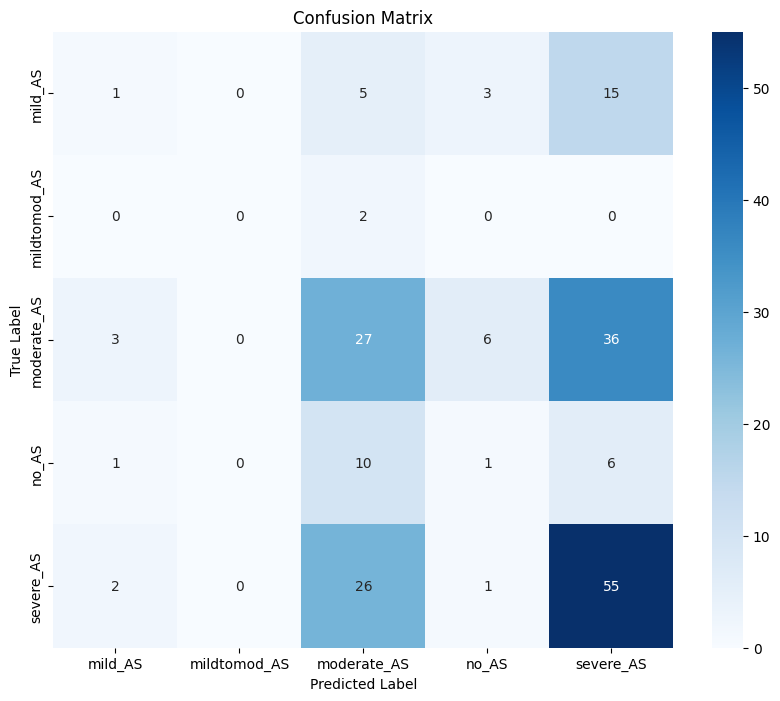

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming your label encoder is available as view_label_encoder
class_names = supervised_dataset.diagnosis_label_encoder.classes_  # Update if you use a different encoder

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [23]:
from google.colab import files
files.download('best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>